In [1]:
# 把包根目录加入 sys.path（兼容脚本和 Jupyter）
import sys
import os
from typing import Dict, Callable, Any
import torch
import numpy as np
import json
from typing import List, Tuple, Dict

if '__file__' in globals():
    # 脚本方式运行
    CURR_DIR = os.path.dirname(os.path.abspath(__file__))
else:
    # Jupyter/REPL：用当前工作目录或你指定的项目路径
    CURR_DIR = os.getcwd()  # 或者直接写成项目根：/path/to/your/project

PROJECT_ROOT = os.path.abspath(os.path.join(CURR_DIR, '../'))  # 按需调整层级
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from eval_plus_nd import (
    VQvaePlusEval, get_all_plus_pairs, _get_interpolate_plus_pairs, EncInfo, PlusInfo, mode_emb_label_dict, plus_accuracy,
    calc_emb_select_plus_accu
)
from VQVAE import VQVAE, get_all_code_embs
from common_func import (load_config_from_exp_name, record_num_list, EXP_ROOT, RandomGaussianBlur, make_dataset_trans,
                         find_optimal_checkpoint_num_by_train_config, solve_label_emb_one2one_matching)
from dataloader_plus import MultiImgDataset
from dataloader import SingleImgDataset, load_enc_eval_data_with_style
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
from shared import DEVICE


def make_data_loader(sub_cfg: Dict[str, Any],
                     dataset_cls: Callable[..., Any]) -> DataLoader:
    aug_t = sub_cfg.get('augment_times', 1)
    path_list = sub_cfg['eval_set_path_list']
    is_blur = sub_cfg.get('is_blur', False)
    blur_cfg = sub_cfg.get('blur_config', {})
    trans = make_dataset_trans(is_blur, blur_cfg)
    # 如果有多个 set_path, 创建多个 dataset 并合并
    datasets = ConcatDataset([dataset_cls(path, augment_times=aug_t, transform=trans)
                              for path in path_list])
    data_loader = DataLoader(datasets, batch_size=128, shuffle=False)
    return data_loader



In [2]:
from typing import Literal


def interpolate_plus_eval(
    loaded_model: VQVAE,
    enc_z: List[EncInfo],
    plus_z: List[PlusInfo],
    label_mode: Literal["selection", "mode_dict"] = "selection"
):
    """
    执行 enc_z 的插值加法评估。
    """
    half = 0.5
    a_list, b_list, c_list = get_all_plus_pairs(plus_z)
    smallest = min(min(a_list), min(b_list))
    largest = max(max(a_list), max(b_list))

    pair_strings = set()
    a_itp_list, b_itp_list, style_enc_list, label_c, a_itp_label_list, b_itp_label_list = [], [], [], [], [], []
    def is_valid_pair(a, b):
        return smallest < a < largest and smallest < b < largest and f"{a}-{b}" not in pair_strings

    for a, b, c in zip(a_list, b_list, c_list):
        a_m = a - half
        b_p = b + half
        if is_valid_pair(a_m, b_p):
            pair_strings.add(f"{a_m}-{b_p}")
            a_itp, b_itp, style_enc = _get_interpolate_plus_pairs(
                a-1, a, b, b+1, enc_z
            )
            a_itp_list.append(a_itp)
            b_itp_list.append(b_itp)
            style_enc_list.append(style_enc)
            label_c.append(c)
            a_itp_label_list.append((a-0.5))
            b_itp_label_list.append((b+0.5))

        a_p = a + half
        b_m = b - half
        if is_valid_pair(a_p, b_m):
            pair_strings.add(f"{a_p}-{b_m}")
            a_itp, b_itp, style_enc = _get_interpolate_plus_pairs(
                a+1, a, b, b-1, enc_z
            )
            a_itp_list.append(a_itp)
            b_itp_list.append(b_itp)
            style_enc_list.append(style_enc)
            label_c.append(c)
            a_itp_label_list.append((a+0.5))
            b_itp_label_list.append((b-0.5))


    a_itp_tensor = torch.stack(a_itp_list, dim=0).to(DEVICE)
    b_itp_tensor = torch.stack(b_itp_list, dim=0).to(DEVICE)
    style_enc_tensor = torch.stack(style_enc_list, dim=0).to(DEVICE)
    plus_emb = loaded_model.plus(a_itp_tensor, b_itp_tensor)[0]
    plus_emb_idx = loaded_model.find_indices(plus_emb, False)
    plus_emb_cycle = loaded_model.batch_encode_to_z(
        loaded_model.batch_decode_from_z(torch.cat((plus_emb, style_enc_tensor), -1))
    )[0]
    plus_emb_cycle_idx = loaded_model.find_indices(plus_emb_cycle, True)
    plus_itp_list = []
    for j in range(len(plus_emb_idx)):
        plus_itp_list.append(PlusInfo(
            emb_idx=plus_emb_idx[j],
            emb_value=plus_emb[j],
            cycle_emb_idx=plus_emb_cycle_idx[j],
            cycle_emb_value=plus_emb_cycle[j],
            label_c=label_c[j],
        ))
    if label_mode == "mode_dict":
        emb_label_dict = mode_emb_label_dict(enc_z)
        accu, accu_cycle = plus_accuracy(emb_label_dict, plus_itp_list)
        print(emb_label_dict)
        plus_itp_label_list = [emb_label_dict.get(int(plusinfo.emb_idx.cpu()), -1) for plusinfo in plus_itp_list]
    elif label_mode == "selection":
        accu_mean, accu_cycle_mean, plus_itp_label_list, plus_itp_cycle_label_list = calc_emb_select_plus_accu(
            enc_z, plus_itp_list
        )
    return a_itp_label_list, b_itp_label_list, plus_itp_label_list



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib
matplotlib.use("TkAgg")   # 或者 "QtAgg" / "Qt5Agg" / "MacOSX"(mac)
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:


def run_interpolation_eval(exp_name: str, sub_exp: str, ckpt: str, label_mode: Literal["selection", "mode_dict"] = "selection"):
    config = load_config_from_exp_name(exp_name)
    exp_path = os.path.join(EXP_ROOT, exp_name)
    ckpt_path = os.path.join(exp_path, sub_exp, ckpt)
    sub_config = config['eval_config']['interpolate_configs'][0]
    data_loader = make_data_loader(sub_config, MultiImgDataset)

    interpolate_evaler = VQvaePlusEval(config)
    interpolate_evaler.reload_model(ckpt_path)

    all_enc_z, all_plus_z = interpolate_evaler.load_plusZ_eval_data(data_loader)
    a_itp_label_list, b_itp_label_list, plus_itp_label_list = interpolate_plus_eval(interpolate_evaler.model,
                                                                    all_enc_z, all_plus_z, label_mode=label_mode)
    print("A itp labels:", a_itp_label_list)
    print("B itp labels:", b_itp_label_list)
    print("C itp labels:", plus_itp_label_list)
    return a_itp_label_list, b_itp_label_list, plus_itp_label_list

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import math

def plot_interpolation_results(
    a_itp_label_list: List[float],
    b_itp_label_list: List[float],
    plus_itp_label_list: List[float],
    title: str = ''
):
    """
    画出插值加法评估结果的分组折线图。
    横轴：A itp label
    纵轴：C (sum)
    每条折线对应一个 B 值（不同颜色），折线上的点表示该 B 下不同 A 对应的 C（众数聚合）。
    折线旁边有理想参考线 y = A + B（虚线）。
    在 C==-1 出现的 A 位置，用 × 标注（放在 C 轴的下边缘附近）。
    """
    # ==== 粘贴你的数据 ====
    A = np.array(a_itp_label_list)
    B = np.array(b_itp_label_list)
    C = np.array(plus_itp_label_list)

    assert len(A)==len(B)==len(C)

    # ——按 B 分组，并按 A 聚合（同一 A 去掉 -1 后取众数；全 -1 -> NaN；记录是否“出现过 -1”）——
    groups_raw = defaultdict(list)
    for a,b,c in zip(A,B,C):
        groups_raw[b].append((a,c))

    sorted_B = sorted(groups_raw.keys())  # legend 升序

    # 先整理好每条轨迹，便于两遍绘制
    tracks = []  # list of dicts: {'b', 'A_line','C_line','mask_any_invalid'}
    all_y_for_limits = []

    for b in sorted_B:
        pts = groups_raw[b]
        bucket = defaultdict(list)
        for a,c in pts:
            bucket[a].append(c)

        A_sorted = np.array(sorted(bucket.keys()))
        C_agg = []
        any_invalid = []
        for a in A_sorted:
            vals = bucket[a]
            any_invalid.append(any(v == -1 for v in vals))
            valid = [v for v in vals if v != -1]
            if len(valid)==0:
                C_agg.append(np.nan)
            else:
                cnt = Counter(valid)
                C_agg.append(sorted(cnt.items(), key=lambda x:(-x[1], x[0]))[0][0])

        A_line = A_sorted
        C_line = np.array(C_agg, dtype=float)
        mask_any_invalid = np.array(any_invalid, dtype=bool)

        tracks.append({'b': b, 'A_line': A_line, 'C_line': C_line, 'mask_any_invalid': mask_any_invalid})

        if np.isfinite(C_line).any():
            all_y_for_limits.append(C_line[np.isfinite(C_line)])
        all_y_for_limits.append(A_line + b)

    # 计算 y 轴范围，并为 × 预留空间
    yy = np.concatenate(all_y_for_limits)
    ymin = math.floor(yy.min())
    ymax = math.ceil(yy.max())
    y_bottom = ymin - 0.8     # × 的摆放高度
    yticks = np.arange(ymin, ymax+1, 1)  # 每个整数刻度

    # —— 开始绘图（第二遍）——
    cmap = plt.get_cmap('tab20')
    color = {b: cmap(i % 20) for i,b in enumerate(sorted_B)}

    fig, ax = plt.subplots(figsize=(8,6))

    for tr in tracks:
        b = tr['b']
        A_line = tr['A_line']
        C_line = tr['C_line']
        mask_inv = tr['mask_any_invalid']

        # 实测折线 + 理想虚线
        ax.plot(A_line, C_line, '-o', ms=4, lw=1.6, color=color[b], 
                # label=f'B={b:.1f} (n={len(groups_raw[b])})'
                label=f'{b:.1f}'
        )
        ax.plot(A_line, A_line + b, '--', lw=1.0, color=color[b], alpha=0.5)

        # —— 在 C==-1 出现过的 A 位置画 “×” ——（放在统一的 y_bottom）
        if mask_inv.any():
            ax.scatter(A_line[mask_inv], np.full(mask_inv.sum(), y_bottom),
                    marker='x', s=28, color=color[b], alpha=0.9)

    # 轴与外观
    ax.set_ylim(y_bottom - 0.1, ymax + 0.5)
    ax.set_yticks(yticks)
    ax.set_xticks(np.arange(0.5, math.floor(A.max())+1.6, 1.0))

    ax.set_xlabel('1st input (addend)', fontsize=16)
    ax.set_ylabel('Sum', fontsize=16)
    # ax.set_title('Per-B polyline: C over A (solid) with ideal C=A+B (dashed)\n(× marks A positions where any C == -1)')
    ax.set_title(title, fontsize=16)
    ax.grid(True, ls=':', alpha=0.3)
    ax.legend(fontsize=12, ncol=3, frameon=False, loc='lower right', title='2nd input (addend)', title_fontsize=14)

    plt.tight_layout()
    plt.show()



## 选择题法

Loading config from: d:\Projects\Gus Xia\S3Plus\VQ\exp\2025.05.18_10vq_Zc[2]_Zs[0]_edim1_[0-20]_plus1024_1_tripleSet_Fullsymm\train_config.py
No model is loaded
Emb Select Plus Accu: 1.0000, Cycle Accu: 0.9905
A itp labels: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 1.5, 0.5, 1.5, 1.5, 0.5, 1.5, 9.5, 10.5, 9.5, 10.5, 9.5, 10.5, 9.5, 10.5, 10.5, 11.5, 11.5, 12.5, 11.5, 12.5, 11.5, 12.5, 13.5, 13.5, 14.5, 14.5, 15.5, 16.5, 16.5, 17.5, 16.5, 17.5, 18.5, 18.5, 1.5, 2.5, 1.5, 2.5, 2.5, 2.5, 1.5, 2.5, 1.5, 2.5, 1.5, 2.5, 3.5, 2.5, 3.5, 2.5, 3.5, 3.5, 2.5, 3.5, 3.5, 2.5, 3.5, 2.5, 3.5, 3.5, 4.5, 3.5, 4.5, 4.5, 3.5, 4.5, 4.5, 5.5, 4.5, 5.5, 4.5, 5.5, 5.5, 6.5, 6.5, 5.5, 6.5, 5.5, 6.5, 5.5, 6.5, 6.5, 7.5, 7.5, 7.5, 8.5, 7.5, 8.5, 8.5, 9.5, 8.5, 9.5, 8.5, 9.5]
B itp labels: [9.5, 11.5, 12.5, 14.5, 1.5, 19.5, 4.5, 5.5, 0.5, 0.5, 15.5, 14.5, 16.5, 15.5, 18.5, 3.5, 2.5, 1.5, 0.5, 5.5, 4.5, 6.5, 5.5, 7.5, 6.5, 1.5, 0.5, 2.5, 1.5, 6.5, 5.5, 7.5, 6.5, 0.5, 1.5, 0.5, 3.5, 2.5, 0.5, 2.5, 1.

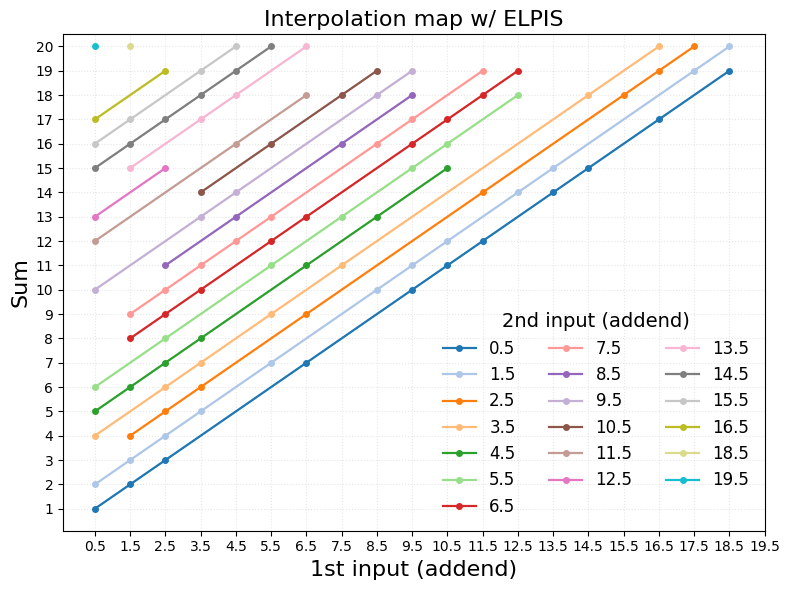

In [12]:
exp_name = "2025.05.18_10vq_Zc[2]_Zs[0]_edim1_[0-20]_plus1024_1_tripleSet_Fullsymm"
sub_exp = "1"
ckpt = "checkpoint_48000.pt"
a_itp_label_list, b_itp_label_list, plus_itp_label_list = run_interpolation_eval(exp_name, sub_exp, ckpt)
title = "Interpolation map w/ ELPIS"
plot_interpolation_results(
    a_itp_label_list,
    b_itp_label_list,
    plus_itp_label_list,
    title=title
)

Loading config from: d:\Projects\Gus Xia\S3Plus\VQ\exp\2025.05.18_10vq_Zc[2]_Zs[0]_edim1_[0-20]_plus1024_1_tripleSet_Nothing\train_config.py
No model is loaded
Emb Select Plus Accu: 0.5238, Cycle Accu: 0.4667
A itp labels: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 1.5, 0.5, 1.5, 1.5, 0.5, 1.5, 9.5, 10.5, 9.5, 10.5, 9.5, 10.5, 9.5, 10.5, 10.5, 11.5, 11.5, 12.5, 11.5, 12.5, 11.5, 12.5, 13.5, 13.5, 14.5, 14.5, 15.5, 16.5, 16.5, 17.5, 16.5, 17.5, 18.5, 18.5, 1.5, 2.5, 1.5, 2.5, 2.5, 2.5, 1.5, 2.5, 1.5, 2.5, 1.5, 2.5, 3.5, 2.5, 3.5, 2.5, 3.5, 3.5, 2.5, 3.5, 3.5, 2.5, 3.5, 2.5, 3.5, 3.5, 4.5, 3.5, 4.5, 4.5, 3.5, 4.5, 4.5, 5.5, 4.5, 5.5, 4.5, 5.5, 5.5, 6.5, 6.5, 5.5, 6.5, 5.5, 6.5, 5.5, 6.5, 6.5, 7.5, 7.5, 7.5, 8.5, 7.5, 8.5, 8.5, 9.5, 8.5, 9.5, 8.5, 9.5]
B itp labels: [9.5, 11.5, 12.5, 14.5, 1.5, 19.5, 4.5, 5.5, 0.5, 0.5, 15.5, 14.5, 16.5, 15.5, 18.5, 3.5, 2.5, 1.5, 0.5, 5.5, 4.5, 6.5, 5.5, 7.5, 6.5, 1.5, 0.5, 2.5, 1.5, 6.5, 5.5, 7.5, 6.5, 0.5, 1.5, 0.5, 3.5, 2.5, 0.5, 2.5, 1.5

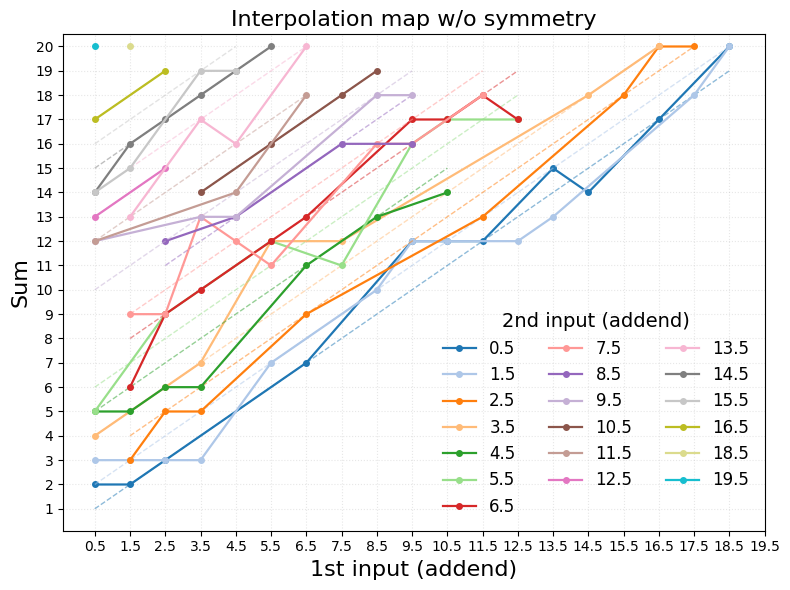

In [13]:
exp_name = "2025.05.18_10vq_Zc[2]_Zs[0]_edim1_[0-20]_plus1024_1_tripleSet_Nothing"
sub_exp = "1"
ckpt = "checkpoint_48000.pt"
a_itp_label_list, b_itp_label_list, plus_itp_label_list = run_interpolation_eval(exp_name, sub_exp, ckpt)
title = "Interpolation map w/o symmetry"
plot_interpolation_results(
    a_itp_label_list,
    b_itp_label_list,
    plus_itp_label_list,
    title=title
)

## 一夫多妻法

Loading config from: d:\Projects\Gus Xia\S3Plus\VQ\exp\2025.05.18_10vq_Zc[2]_Zs[0]_edim1_[0-20]_plus1024_1_tripleSet_Fullsymm\train_config.py
No model is loaded
{15: 0, 47: 10, 48: 12, 43: 13, 2: 15, 17: 2, 60: 20, 61: 5, 31: 6, 18: 1, 20: 16, 54: 17, 84: 19, 71: 3, 91: 4, 49: 11, 51: 7, 5: 14, 34: 18, 1: 8, 41: 9}
A itp labels: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 1.5, 0.5, 1.5, 1.5, 0.5, 1.5, 9.5, 10.5, 9.5, 10.5, 9.5, 10.5, 9.5, 10.5, 10.5, 11.5, 11.5, 12.5, 11.5, 12.5, 11.5, 12.5, 13.5, 13.5, 14.5, 14.5, 15.5, 16.5, 16.5, 17.5, 16.5, 17.5, 18.5, 18.5, 1.5, 2.5, 1.5, 2.5, 2.5, 2.5, 1.5, 2.5, 1.5, 2.5, 1.5, 2.5, 3.5, 2.5, 3.5, 2.5, 3.5, 3.5, 2.5, 3.5, 3.5, 2.5, 3.5, 2.5, 3.5, 3.5, 4.5, 3.5, 4.5, 4.5, 3.5, 4.5, 4.5, 5.5, 4.5, 5.5, 4.5, 5.5, 5.5, 6.5, 6.5, 5.5, 6.5, 5.5, 6.5, 5.5, 6.5, 6.5, 7.5, 7.5, 7.5, 8.5, 7.5, 8.5, 8.5, 9.5, 8.5, 9.5, 8.5, 9.5]
B itp labels: [9.5, 11.5, 12.5, 14.5, 1.5, 19.5, 4.5, 5.5, 0.5, 0.5, 15.5, 14.5, 16.5, 15.5, 18.5, 3.5, 2.5, 1.5, 0.5, 

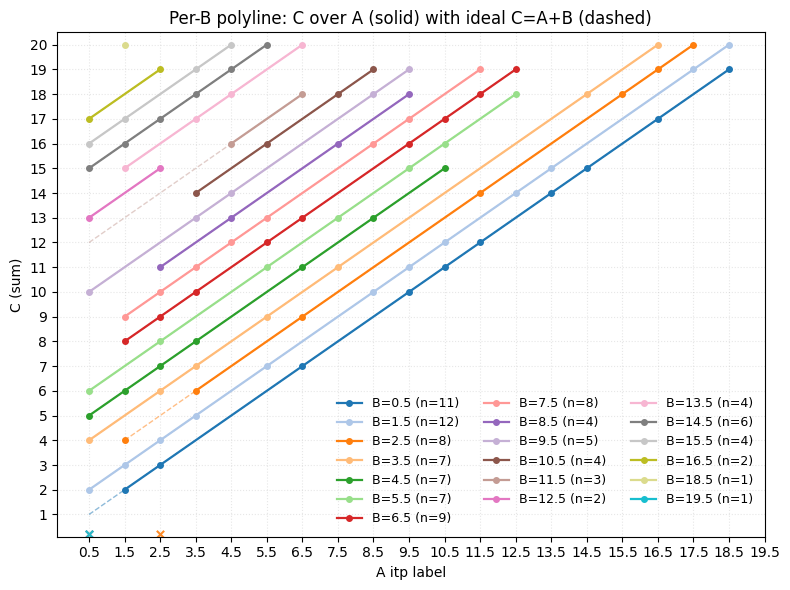

In [14]:
exp_name = "2025.05.18_10vq_Zc[2]_Zs[0]_edim1_[0-20]_plus1024_1_tripleSet_Fullsymm"
sub_exp = "1"
ckpt = "checkpoint_48000.pt"
label_mode = "mode_dict"
a_itp_label_list, b_itp_label_list, plus_itp_label_list = run_interpolation_eval(exp_name, sub_exp, ckpt, label_mode=label_mode)
plot_interpolation_results(
    a_itp_label_list,
    b_itp_label_list,
    plus_itp_label_list,
)

Loading config from: d:\Projects\Gus Xia\S3Plus\VQ\exp\2025.05.18_10vq_Zc[2]_Zs[0]_edim1_[0-20]_plus1024_1_tripleSet_Nothing\train_config.py
No model is loaded
{50: 0, 56: 10, 57: 12, 36: 13, 67: 15, 19: 2, 85: 20, 4: 5, 6: 6, 0: 1, 82: 16, 76: 17, 74: 19, 55: 3, 5: 4, 17: 11, 2: 7, 28: 14, 73: 18, 8: 8, 98: 9}
A itp labels: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 1.5, 0.5, 1.5, 1.5, 0.5, 1.5, 9.5, 10.5, 9.5, 10.5, 9.5, 10.5, 9.5, 10.5, 10.5, 11.5, 11.5, 12.5, 11.5, 12.5, 11.5, 12.5, 13.5, 13.5, 14.5, 14.5, 15.5, 16.5, 16.5, 17.5, 16.5, 17.5, 18.5, 18.5, 1.5, 2.5, 1.5, 2.5, 2.5, 2.5, 1.5, 2.5, 1.5, 2.5, 1.5, 2.5, 3.5, 2.5, 3.5, 2.5, 3.5, 3.5, 2.5, 3.5, 3.5, 2.5, 3.5, 2.5, 3.5, 3.5, 4.5, 3.5, 4.5, 4.5, 3.5, 4.5, 4.5, 5.5, 4.5, 5.5, 4.5, 5.5, 5.5, 6.5, 6.5, 5.5, 6.5, 5.5, 6.5, 5.5, 6.5, 6.5, 7.5, 7.5, 7.5, 8.5, 7.5, 8.5, 8.5, 9.5, 8.5, 9.5, 8.5, 9.5]
B itp labels: [9.5, 11.5, 12.5, 14.5, 1.5, 19.5, 4.5, 5.5, 0.5, 0.5, 15.5, 14.5, 16.5, 15.5, 18.5, 3.5, 2.5, 1.5, 0.5, 5.5,

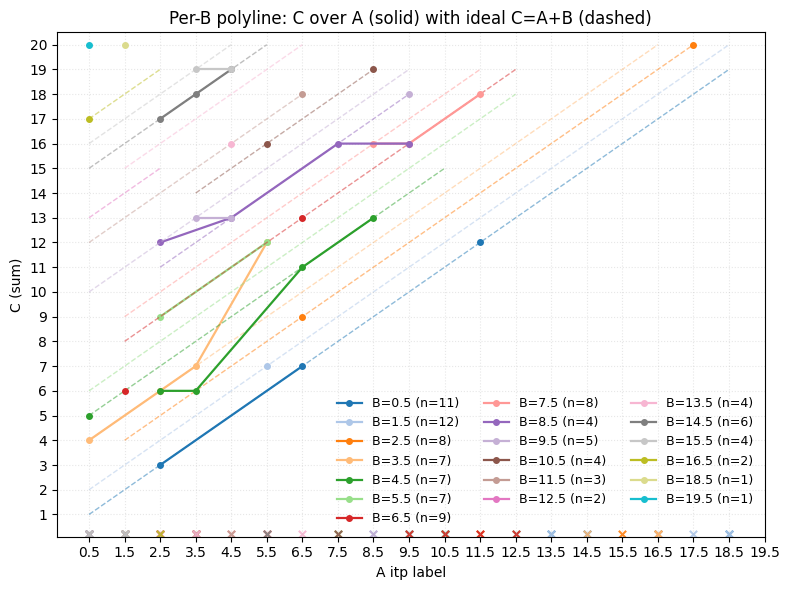

In [15]:
exp_name = "2025.05.18_10vq_Zc[2]_Zs[0]_edim1_[0-20]_plus1024_1_tripleSet_Nothing"
sub_exp = "1"
ckpt = "checkpoint_48000.pt"
label_mode = "mode_dict"
a_itp_label_list, b_itp_label_list, plus_itp_label_list = run_interpolation_eval(exp_name, sub_exp, ckpt, label_mode=label_mode)
plot_interpolation_results(
    a_itp_label_list,
    b_itp_label_list,
    plus_itp_label_list,
)